<a href="https://colab.research.google.com/github/TongQM/SONAR_VLM/blob/main/Project_VL_Frameworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import json
import torch
import numpy as np
import torch.nn.functional as F
from tqdm import tqdm
from PIL import Image
from transformers import BlipProcessor, BlipModel
from sklearn.metrics import label_ranking_average_precision_score, ndcg_score

In [ ]:
# import os
# from google.colab import drive

# drive.mount('/content/gdrive')
# os.chdir('/content/gdrive/My Drive/')

In [ ]:
# !rm *.jpg

In [10]:
# ====== Vision Model Loader (Supports Different VLM Frameworks) ======
def load_vision_model(vlm_name, vision_model_name):
    """Load a VLM and extract its vision encoder."""
    if vlm_name.lower() == "blip":
        model_name_map = {
            "ViT-B": "Salesforce/blip-image-captioning-base",
            "ViT-L": "Salesforce/blip-image-captioning-large"
        }
        model_name = model_name_map.get(vision_model_name, "ViT-B")
        model = BlipModel.from_pretrained(model_name)
        processor = BlipProcessor.from_pretrained(model_name)
        return model.vision_model, processor
    elif vlm_name.lower() == "openclip":
        from open_clip import create_model_and_transforms
        model, preprocess = create_model_and_transforms(vision_model_name, pretrained="laion2b_s34b_b79k")
        return model.visual, preprocess
    # Add support for other VLMs (ALBEF, Flamingo, etc.)
    else:
        raise ValueError(f"VLM '{vlm_name}' not supported.")

# ====== Load Dataset (Supports COCO, Flickr30k, Custom Datasets) ======
def load_dataset(dataset_name, annotation_file):
    """Load dataset annotations and create an image-text mapping."""
    if dataset_name.lower() in ["coco", "flickr30k"]:
        with open(annotation_file, "r") as f:
            data = json.load(f)

        image_id_to_captions = {}
        for ann in data["annotations"]:
            image_id = ann["image_id"]
            caption = ann["caption"].strip().lower()
            if image_id not in image_id_to_captions:
                image_id_to_captions[image_id] = []
            image_id_to_captions[image_id].append(caption)

        return image_id_to_captions, data["images"]
    else:
        raise ValueError(f"Dataset '{dataset_name}' not supported.")

# ====== Compute Image Embeddings ======
def compute_image_embeddings(image_folder, dataset, vlm_name, vision_model_name):
    """Extract embeddings for images using a vision encoder from a given VLM."""
    vision_model, processor = load_vision_model(vlm_name, vision_model_name)
    image_embeddings = []
    image_ids = []

    for image_info in tqdm(dataset, desc=f"Extracting {vlm_name} {vision_model_name} embeddings"):
        image_id = image_info["id"]
        image_filename = image_info["file_name"]
        image_path = os.path.join(image_folder, image_filename)

        if not os.path.exists(image_path):
            continue

        # Load and preprocess image
        image = Image.open(image_path).convert("RGB")
        if vlm_name.lower() == "blip":
            inputs = processor(images=image, return_tensors="pt")
            with torch.no_grad():
                vision_output = vision_model(**inputs).last_hidden_state
                image_embedding = vision_output.mean(dim=1)  # Pooling
        elif vlm_name.lower() == "openclip":
            image = processor(image).unsqueeze(0)
            with torch.no_grad():
                image_embedding = vision_model(image)

        image_embeddings.append(image_embedding.squeeze(0))
        image_ids.append(image_id)

    return torch.stack(image_embeddings), image_ids

# ====== Compute Retrieval Metrics ======
def compute_retrieval_metrics(image_embeddings, image_ids, image_id_to_captions, text_encoder, k_values=[1, 5, 10]):
    """Evaluate retrieval performance using Recall@K, mAP, and NDCG."""
    recall_scores = {k: 0 for k in k_values}
    all_similarities = []
    all_relevancies = []

    num_queries = len(image_id_to_captions)

    for image_id, captions in tqdm(image_id_to_captions.items(), desc="Evaluating Retrieval Metrics"):
        text_embeddings = [text_encoder.encode(caption) for caption in captions]
        text_embedding = torch.mean(torch.stack(text_embeddings), dim=0)  # Average multiple captions

        # Compute similarity between text and all images
        similarities = F.cosine_similarity(image_embeddings, text_embedding)

        # Rank images by similarity
        ranked_indices = similarities.argsort(descending=True)
        ranked_image_ids = [image_ids[i] for i in ranked_indices]

        # Compute Recall@K
        for k in k_values:
            top_k = set(ranked_image_ids[:k])
            if image_id in top_k:
                recall_scores[k] += 1

        # Store data for mAP and NDCG
        relevancy = np.array([1 if img_id == image_id else 0 for img_id in ranked_image_ids])
        all_similarities.append(similarities.numpy())
        all_relevancies.append(relevancy)

    # Normalize Recall@K
    for k in k_values:
        recall_scores[k] /= num_queries

    # Compute mAP
    mAP_score = label_ranking_average_precision_score(all_relevancies, all_similarities)

    # Compute NDCG
    ndcg_value = np.mean([ndcg_score([rel], [sim]) for rel, sim in zip(all_relevancies, all_similarities)])

    return recall_scores, mAP_score, ndcg_value


In [11]:
# ====== Run Evaluation Framework ======
# get text encoder
# text_encoder =
dataset_name = "coco"  # Change to "flickr30k" or another dataset
annotation_file = "coco_data/annotations/captions_train2017.json"  # TODO: Change this
image_folder = "coco_data/annotations/train2017"  # TODO: Change this

# Load dataset
image_id_to_captions, dataset = load_dataset(dataset_name, annotation_file)

# Test Different VLMs and Vision Encoders
vlm_models = {
    "blip": ["ViT-B", "ViT-L"],
    "openclip": ["ViT-B/32", "ViT-L/14"]
}

for vlm_name, vision_models in vlm_models.items():
    for vision_model in vision_models:
        print(f"\nEvaluating VLM: {vlm_name}, Vision Model: {vision_model}")

        # get vlm framework
        # get vision encoders from framework
        # Compute image embeddings
        image_embeddings, image_ids = compute_image_embeddings(image_folder, dataset, vlm_name, vision_model)

        target_sonar_embedding =


        # evaluate metric
        # r@k
        # mAP
        # ndcg
        recall_scores, mAP, ndcg = compute_retrieval_metrics(image_embeddings, image_ids, image_id_to_captions, text_encoder)

        # Print results
        print(f"VLM: {vlm_name}, Vision Model: {vision_model}")
        print(f"R@1: {recall_scores[1]:.4f}, R@5: {recall_scores[5]:.4f}, R@10: {recall_scores[10]:.4f}")
        print(f"mAP: {mAP:.4f}, NDCG: {ndcg:.4f}")

SyntaxError: invalid syntax (1532684310.py, line 26)

## **DataLoad：（Coco 2017）**

Download datasets: Coco 2017

In [ ]:
import os
import requests
from zipfile import ZipFile

# 定义：2017版的 COCO 数据集 URL
COCO_ANNOTATIONS_URL = "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
COCO_IMAGES_URL = "http://images.cocodataset.org/zips/train2017.zip"

DATA_DIR = "./coco_data"
ANNOTATIONS_ZIP = os.path.join(DATA_DIR, "annotations_trainval2017.zip")
IMAGES_ZIP = os.path.join(DATA_DIR, "train2017.zip")
ANNOTATIONS_DIR = os.path.join(DATA_DIR, "annotations")
IMAGES_DIR = os.path.join(DATA_DIR, "train2017")

# 创建数据存储目录
os.makedirs(DATA_DIR, exist_ok=True)

def download_file(url, save_path):
    """ 显示下载进度 """
    with requests.get(url, stream=True) as response:
        response.raise_for_status()
        total_size = int(response.headers.get('content-length', 0))
        downloaded = 0
        with open(save_path, 'wb') as file:
            for chunk in response.iter_content(chunk_size=8192):
                file.write(chunk)
                downloaded += len(chunk)
                progress = (downloaded / total_size) * 100
                print(f"\rDownloading {os.path.basename(save_path)}: {progress:.2f}%", end="")

    print(f"\nDownloaded {save_path}")

def extract_zip(zip_path, extract_to):
    """ 解压 ZIP 文件 """
    print(f"Extracting {zip_path} to {extract_to} ...")
    with ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Extraction completed: {extract_to}")

# 下载 Annotations（captions_train2017.json）
if not os.path.exists(ANNOTATIONS_DIR):
    download_file(COCO_ANNOTATIONS_URL, ANNOTATIONS_ZIP)
    extract_zip(ANNOTATIONS_ZIP, DATA_DIR)

# 下载 Train2017 图像
if not os.path.exists(IMAGES_DIR):
    download_file(COCO_IMAGES_URL, IMAGES_ZIP)
    extract_zip(IMAGES_ZIP, DATA_DIR)

print("COCO2017 数据集已下载并解压完成")

# 目录：
annotation_file = os.path.join(ANNOTATIONS_DIR, "captions_train2017.json")
image_folder = IMAGES_DIR

print(f"Annotation File: {annotation_file}")
print(f"Image Folder: {image_folder}")


Downloaded ./coco_data/annotations_trainval2017.zip
Extracting ./coco_data/annotations_trainval2017.zip to ./coco_data ...
Extraction completed: ./coco_data
Downloaded ./coco_data/train2017.zip
Extracting ./coco_data/train2017.zip to ./coco_data ...
Extraction completed: ./coco_data
COCO2017 数据集已下载并解压完成
Annotation File: ./coco_data/annotations/captions_train2017.json
Image Folder: ./coco_data/train2017


In [ ]:
import json
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn.utils.rnn as rnn_utils
from transformers import CLIPProcessor, BlipProcessor

In [ ]:
class COCODataset(Dataset):
    def __init__(self, annotation_file, image_folder, model_type="clip"):
        """
        COCO Dataset，支持 CLIP 和 BLIP
        - if model_type="clip", apply CLIPProcessor
        - if model_type="blip", apply BlipProcessor
        """
        self.image_folder = image_folder
        self.model_type = model_type.lower()

        # select Processor depending on model type:
        if self.model_type == "clip":
            self.processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        elif self.model_type == "blip":
            self.processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
        else:
            raise ValueError("model_type 必须是 'clip' 或 'blip'") #或者你们要用其他的也行，在这边切就好

        # 读取 annotations JSON
        with open(annotation_file, 'r') as f:
            data = json.load(f)

        self.image_id_to_captions = {}
        self.image_data = []

        #（image_id → caption）
        for ann in data['annotations']:
            image_id = ann['image_id']
            caption = ann['caption']

            if image_id not in self.image_id_to_captions:
                self.image_id_to_captions[image_id] = []
            self.image_id_to_captions[image_id].append(caption)

        #（image_id → file_name）
        for img in data['images']:
            image_id = img['id']
            image_filename = img['file_name']
            image_path = os.path.join(image_folder, image_filename)

            if image_id in self.image_id_to_captions:  # 确保该图片有对应 captions
                captions = self.image_id_to_captions[image_id]
                self.image_data.append((image_path, captions))

    def __len__(self):
        return len(self.image_data)

    def __getitem__(self, idx):
        """返回 处理后的图像 (Tensor) 和 tokenized 文本"""
        image_path, captions = self.image_data[idx]
        image = Image.open(image_path).convert('RGB')

        # 选一个 caption
        text = captions[0]

        # if: CLIP
        if self.model_type == "clip":
            image = self.processor(images=image, return_tensors="pt")["pixel_values"].squeeze(0)  # shape (3, 224, 224)
            text = self.processor(text=text, return_tensors="pt")["input_ids"].squeeze(0)  # Tokenized text

        # if: BLIP
        elif self.model_type == "blip":
            image = self.processor(images=image, return_tensors="pt")["pixel_values"].squeeze(0)  # shape (3, 224, 224)
            text = self.processor(text=text, return_tensors="pt")["input_ids"].squeeze(0)  # Tokenized text

        return image, text

def collate_fn(batch):
    images, texts = zip(*batch)  # 拆分 batch
    images = torch.stack(images)  # 组合图像 tensor

    # text padding: (length difference otherwise)
    texts_padded = rnn_utils.pad_sequence(texts, batch_first=True, padding_value=0)

    return images, texts_padded



In [ ]:
image_folder = 'coco_data/train2017'

In [ ]:
# input type of model: blip or clip
model_type = "clip"

# 创建 Dataset 和 DataLoader
dataset = COCODataset(annotation_file, image_folder, model_type=model_type)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2,collate_fn=collate_fn)



Visualize datasets (coco) 2017

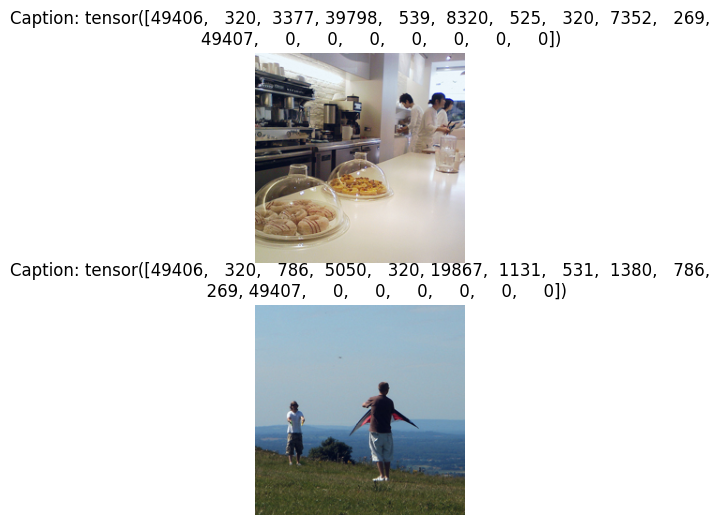

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

for images, texts in dataloader:
    break  # 只取一个 batch 进行可视化

# Tensor back to NumPy
def tensor_to_image(tensor):
    img = tensor.permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())  # normalize
    return img

#graph showing
num_samples = min(2, len(images))  # show num of pic
fig, axes = plt.subplots(2, num_samples//2, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    img = tensor_to_image(images[i])
    ax.imshow(img)
    ax.set_title(f"Caption: {texts[i]}")
    ax.axis("off")

plt.show()

In [ ]:
!ls coco_data/

annotations  annotations_trainval2017.zip  train2017  train2017.zip


# **DataLoad：（Flickr30k）**

download data(Flickr30k)

Data loader:

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from datasets import load_dataset
from transformers import CLIPProcessor, BlipProcessor

In [ ]:
class Flickr30kDataset(Dataset):
    def __init__(self, model_type="clip"):
        """
        Flickr30k Dataset，支持 CLIP 和 BLIP
        - if model_type="clip" , apply CLIPProcessor
        - if model_type="blip", apply BlipProcessor
        """
        self.dataset = load_dataset("nlphuji/flickr30k", split="train")
        self.model_type = model_type.lower()

        # 选择 Processor
        if self.model_type == "clip":
            self.processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        elif self.model_type == "blip":
            self.processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
        else:
            raise ValueError("model_type 必须是 'clip' 或 'blip'")

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        """返回 处理后的图像 (Tensor) 和 tokenized 文本"""
        sample = self.dataset[idx]
        image = sample["image"]  # Hugging Face datasets 自动加载 Image
        caption = sample["caption"]

        if not isinstance(image, Image.Image):
            image = Image.fromarray(image)

        image = self.processor(images=image, return_tensors="pt")["pixel_values"].squeeze(0)
        text = self.processor(text=caption, return_tensors="pt")["input_ids"].squeeze(0)

        return image, text

def collate_fn(batch):
    images, texts = zip(*batch)  # 拆分 batch
    images = torch.stack(images)  # 组合图像 tensor
    texts = torch.nn.utils.rnn.pad_sequence(texts, batch_first=True, padding_value=0)  # 填充文本

    return images, texts


In [ ]:

model_type = "clip"  # 你可以改成 "blip"

dataloader = DataLoader(Flickr30kDataset(model_type=model_type),
                        batch_size=32, shuffle=True, num_workers=2, collate_fn=collate_fn)

# 读取一个 batch 测试
for images, texts in dataloader:
    print(f"Batch images shape: {images.shape}")  # (batch_size, 3, 224, 224)
    print(f"Batch texts shape: {texts.shape}")  # (batch_size, max_seq_length)
    break  # 只跑一个 batch

ValueError: Unknown split "train". Should be one of ['test'].